In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, time
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

In [2]:
transform = transforms.ToTensor()

In [3]:
cifar_train = datasets.CIFAR10(root="../PYTORCH_NOTEBOOKS/Data/",train=True,download=True,transform=transform)
cifar_test = datasets.CIFAR10(root="../PYTORCH_NOTEBOOKS/Data/",train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
cifar_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../PYTORCH_NOTEBOOKS/Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
cifar_test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../PYTORCH_NOTEBOOKS/Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
torch.manual_seed(42)

train_loader = DataLoader(dataset=cifar_train,batch_size=50,shuffle=True)
test_loader = DataLoader(dataset=cifar_test,batch_size=50,shuffle=False)

In [7]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [8]:
for img, label in train_loader:
    break

In [9]:
label

tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
        2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
        2, 3])

Labels: [6 0 4 1 2 7 9 4 7 8 4 5 6 0 4 2 0 1 6 1 4 3 2 3 2 4 0 7 5 1 8 6 3 3 7 0 4
 1 7 1 3 1 1 5 6 3 7 8 2 3]
Class:  frog plane  deer   car  bird horse truck  deer horse  ship  deer   dog  frog plane  deer  bird plane   car  frog   car  deer   cat  bird   cat  bird  deer plane horse   dog   car  ship  frog   cat   cat horse plane  deer   car horse   car   cat   car   car   dog  frog   cat horse  ship  bird   cat


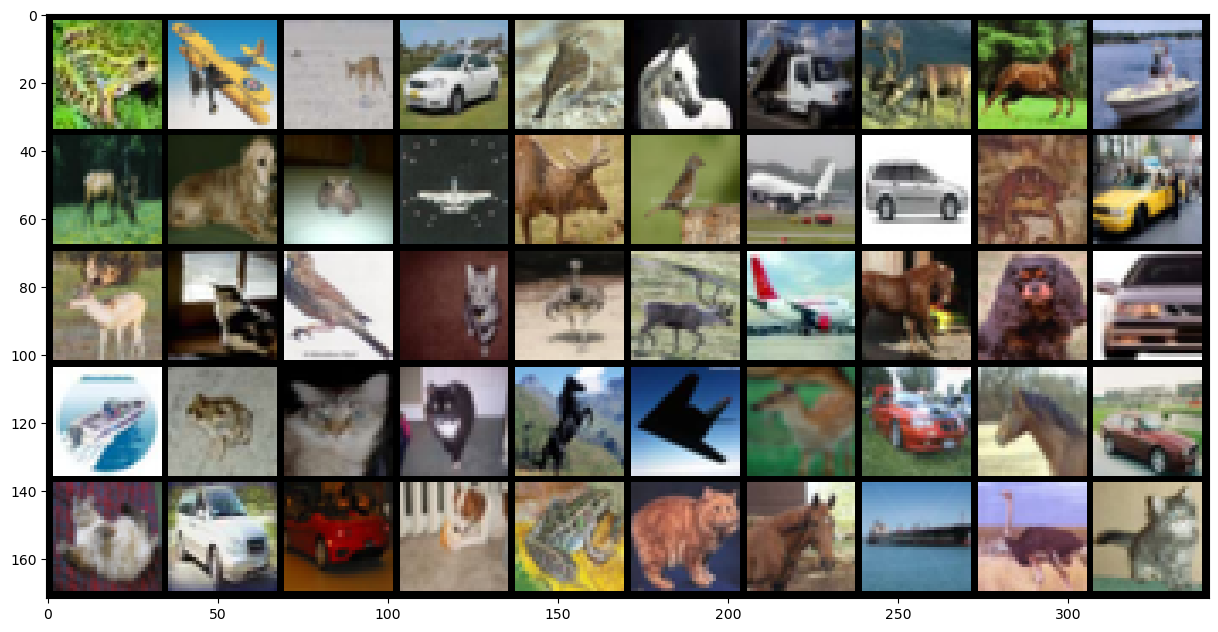

In [10]:
print("Labels:", label.numpy())
print("Class:",*np.array([class_names[i] for i in label]))

images = make_grid(img,nrow=10)
plt.figure(figsize=(15,9))
plt.imshow(np.transpose(images.numpy(),(1,2,0)));

In [11]:
len(class_names)

10

In [12]:
img[0].shape

torch.Size([3, 32, 32])

In [13]:
class ConvolutionalNeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,5,1) # 14,14,32
        self.conv2 = nn.Conv2d(32,48,3,1) # 6,6,48
        self.conv3 = nn.Conv2d(48,74,3,1) # 2,2,74
        self.fc1 = nn.Linear(2*2*74,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,2*2*74) # Flatten the input
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [14]:
torch.manual_seed(42)

model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 74, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [15]:
total_parameters = 0

for param in model.parameters():
    print(param.numel())
    total_parameters += param.numel()

print("Total model parameters:",total_parameters)

2400
32
13824
48
31968
74
37888
128
8192
64
640
10
Total model parameters: 95268


In [16]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [17]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [18]:
start_time = time.time()

epochs = 10

# TRACKERS
train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predictions = torch.max(y_pred.data,1)[1]
        batch_correct_predictions = (predictions == y_train).sum()
        train_correct += batch_correct_predictions

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 1000 == 0:
            print(f"Epoch {i:2} Batch {batch_no:4} Loss {loss.item():10.8f}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predictions = torch.max(y_val.data,1)[1]
            test_correct += (predictions == y_test).sum()

    loss = criterion(y_val,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Time elapsed in CNN model training: {(time.time()-start_time)/60} minutes")

Epoch  0 Batch 1000 Loss 1.36283374
Epoch  1 Batch 1000 Loss 1.29161632
Epoch  2 Batch 1000 Loss 0.71586001
Epoch  3 Batch 1000 Loss 1.33020735
Epoch  4 Batch 1000 Loss 1.06454766
Epoch  5 Batch 1000 Loss 0.89582479
Epoch  6 Batch 1000 Loss 0.92256284
Epoch  7 Batch 1000 Loss 0.93280393
Epoch  8 Batch 1000 Loss 0.71884042
Epoch  9 Batch 1000 Loss 0.72750640
Time elapsed in CNN model training: 12.250835351149242 minutes


In [19]:
torch.save(model.state_dict(),'cifar_10_classifier.pt') # Save the model for future use

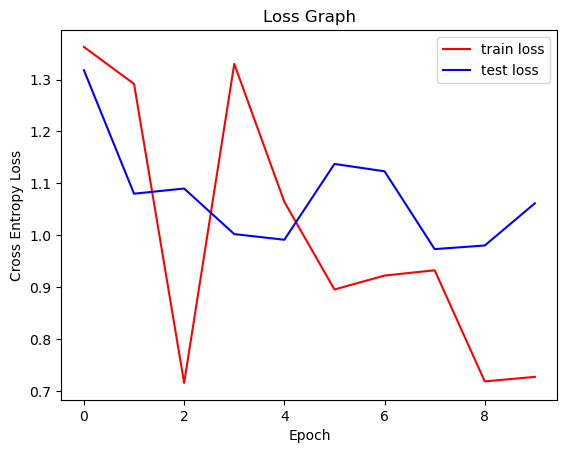

In [20]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend();

In [21]:
train_accuracies = [x/500 for x in train_correct_predictions]
test_accuracies = [x/100 for x in test_correct_predictions]

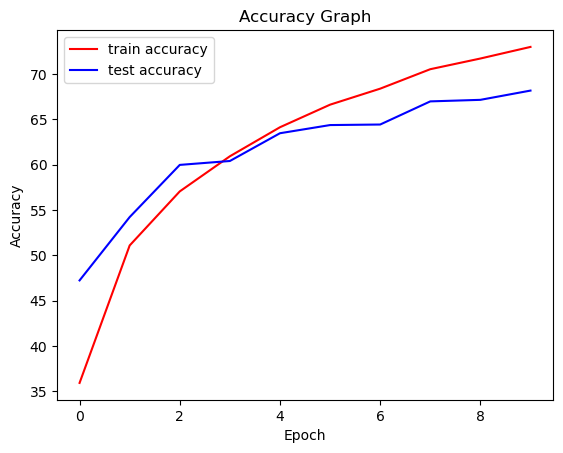

In [22]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [24]:
test_data = DataLoader(dataset=cifar_test,batch_size=10000,shuffle=False)
test_data

In [25]:
model.eval() # Set model to evaluation phase

with torch.no_grad():
    correct = 0

    for X_test, y_test in test_data:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [28]:
print("Test accuracy:",correct.item() / len(cifar_test) * 100)

Test accuracy: 68.16


In [29]:
print("Confusion Matrix:")
print(confusion_matrix(predicted,y_test))

Confusion Matrix:
[[799  27 102  28  37  20  16  25  82  50]
 [ 28 855  10  18   5   8  19   5  41 140]
 [ 24   2 465  55  40  40  41  16   8   5]
 [  3   4  45 370  19 110  36  17   4   7]
 [ 27   4 178 145 723 103  68 104  11   8]
 [  2   2  42 137  11 503  11  28   4   3]
 [  7   7  62  93  51  61 774   4   2   4]
 [  7   4  62  87  93 130  14 766   7   6]
 [ 70  24  21  29  16  11   9   3 815  31]
 [ 33  71  13  38   5  14  12  32  26 746]]


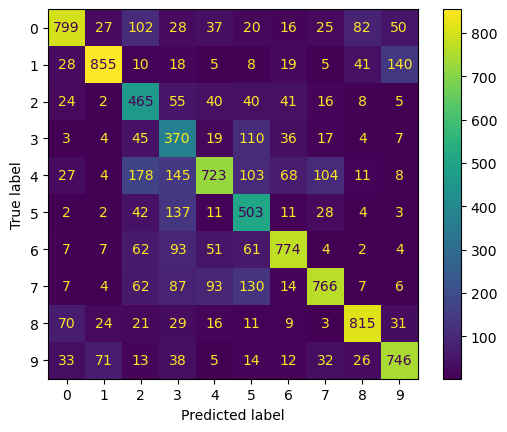

In [31]:
ConfusionMatrixDisplay.from_predictions(predicted,y_test);

In [32]:
print("Classification Report:")
print(classification_report(predicted,y_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1186
           1       0.85      0.76      0.80      1129
           2       0.47      0.67      0.55       696
           3       0.37      0.60      0.46       615
           4       0.72      0.53      0.61      1371
           5       0.50      0.68      0.58       743
           6       0.77      0.73      0.75      1065
           7       0.77      0.65      0.70      1176
           8       0.81      0.79      0.80      1029
           9       0.75      0.75      0.75       990

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.71      0.68      0.69     10000

